# General Information

This notebook demonstrates how the `fastai_sparse` library can be used in semantic segmentation tasks using the example of the [ShapeNet Core55](https://shapenet.cs.stanford.edu/iccv17/) 3D semantic segmentation solution presented in [SparseConvNet example](https://github.com/facebookresearch/SparseConvNet/tree/master/examples/3d_segmentation). 


<img src="https://camo.githubusercontent.com/a94ad53ba6adc857323bd9ba3050805fa16d8aab/687474703a2f2f6d73617676612e6769746875622e696f2f66696c65732f73686170656e65742e706e67" width="480" />

Initial data is subset of ShapeNetCore containing about 17,000 models from 16 shape categories Each category is annotated with 2 to 6 parts and there are 50 different parts annotated in total. 3D shapes are represented as point clouds uniformly sampled from 3D surfaces

Evaluation metric: weighted IoU (see [https://arxiv.org/pdf/1711.10275.pdf](https://arxiv.org/pdf/1711.10275.pdf))

Firstly, it is necessary to upload and prepare the initial data.  See [examples/shapenet_iccv17](examples/shapenet_iccv17)


# Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sparseconvnet as scn
import time
import os, sys
import math
import numpy as np
import pandas as pd
import datetime
import glob
from IPython.display import display, HTML, FileLink
from os.path import join, exists, basename, splitext
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
#from tensorboardX import SummaryWriter
from joblib import cpu_count
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm

#import fastai

# autoreload python modules on the fly when its source is changed
%load_ext autoreload

%autoreload 2

In [3]:
from fastai_sparse import utils
from fastai_sparse.utils import log, log_dict, print_random_states
from fastai_sparse.datasets import find_files
from fastai_sparse.datasets import PointsDataset
#, SparseDataBunch
from fastai_sparse import visualize

from datasets import DataSourceConfig, reader_fn
import transform as T
#from data import merge_fn

In [4]:
assert torch.cuda.is_available()

# Experiment environment / system metrics

In [5]:
experiment_name = 'unet_24_detailed'

In [6]:
utils.watermark()

virtualenv:     (fastai_sparse) 
python:         3.6.8
nvidia driver:  b'384.130'
nvidia cuda:    9.0, V9.0.176
cudnn:          7.1.4
torch:          1.0.1.post2
fastai:         1.0.48
fastai_sparse:  0.0.3.dev0


## Notebook options

In [7]:
utils.wide_notebook()
# uncomment this lines if you want switch off interactive and save visaulisation as screenshoots:
# For rendering run command in terminal:    `chromium-browser --remote-debugging-port=9222`
if  True:
    visualize.options.interactive = False
    visualize.options.save_images = True
    visualize.options.verbose = True
    visualize.options.filename_pattern_image = Path('images', experiment_name, 'fig_{fig_number}')

# Sourse

## Create DataFrames

In [8]:
SOURCE_DIR = Path('data').expanduser()
#SOURCE_DIR = Path('/home/ssd/shapenet_data').expanduser()
assert SOURCE_DIR.exists()

DIR_TRAIN_VAL = SOURCE_DIR / 'train_val'
assert DIR_TRAIN_VAL.exists(), "Hint: run `download_and_split_data.sh` then `convert_to_numpy.ipynb`"

print(SOURCE_DIR)
print(DIR_TRAIN_VAL)

data
data/train_val


In [9]:
categories = [
    "02691156", "02773838", "02954340", "02958343", "03001627", "03261776",
    "03467517", "03624134", "03636649", "03642806", "03790512", "03797390",
    "03948459", "04099429", "04225987", "04379243"
]

classes = [
    'Airplane', 'Bag', 'Cap', 'Car', 'Chair', 'Earphone', 'Guitar', 'Knife',
    'Lamp', 'Laptop', 'Motorbike', 'Mug', 'Pistol', 'Rocket', 'Skateboard',
    'Table'
]

num_classes_by_category = [4, 2, 2, 4, 4, 3, 3, 2, 4, 2, 6, 2, 3, 3, 3, 3]
assert len(categories) == len(classes)

print("Number of categories:", len(categories))

Number of categories: 16


In [10]:
df_train = find_files(path=SOURCE_DIR / 'npy' / 'train', ext='.points.npy', ext_labels='.labels.npy', categories=categories)
df_valid = find_files(path=SOURCE_DIR / 'npy' / 'valid', ext='.points.npy', ext_labels='.labels.npy', categories=categories)

In [11]:
print(len(df_train))
df_train.head()

6955


,example_id,subdir,categ_idx,ext,ext_labels
0,000908,02691156,0,.points.npy,.labels.npy
1,010886,02691156,0,.points.npy,.labels.npy
2,013973,02691156,0,.points.npy,.labels.npy
3,007190,02691156,0,.points.npy,.labels.npy
4,010360,02691156,0,.points.npy,.labels.npy


In [12]:
print(len(df_valid))
df_valid.head()

7052


,example_id,subdir,categ_idx,ext,ext_labels
0,005663,02691156,0,.points.npy,.labels.npy
1,011957,02691156,0,.points.npy,.labels.npy
2,009038,02691156,0,.points.npy,.labels.npy
3,009906,02691156,0,.points.npy,.labels.npy
4,004778,02691156,0,.points.npy,.labels.npy


# DataSets config
You can create PointsDataset using the configuration.

In [13]:
train_source_config = DataSourceConfig(                                       
                                       root_dir=SOURCE_DIR / 'npy' / 'train',                                       
                                       df=df_train,
                                       batch_size=16,
                                       num_workers=12,
                                       num_classes=50,
                                       num_classes_by_category=num_classes_by_category,
                                      )
train_source_config

DataSourceConfig;
   root_dir: data/npy/train
   batch_size: 16
   num_workers: 12
   init_numpy_random_seed: True
   num_classes: 50
   num_classes_by_category: [4, 2, 2, 4, 4, 3, 3, 2, 4, 2, 6, 2, 3, 3, 3, 3]
   class_offsets: [ 0  4  6  8 12 16 19 22 24 28 30 36 38 41 44 47 50]
 Items count: 6955

In [14]:
valid_source_config = DataSourceConfig(                                       
                                       root_dir=SOURCE_DIR / 'npy' / 'valid',
                                       df=df_valid,
                                       batch_size=16,
                                       num_workers=12,
                                       num_classes=50,
                                       num_classes_by_category=num_classes_by_category,
                                       init_numpy_random_seed=False,
                                      )
valid_source_config

DataSourceConfig;
   root_dir: data/npy/valid
   batch_size: 16
   num_workers: 12
   init_numpy_random_seed: False
   num_classes: 50
   num_classes_by_category: [4, 2, 2, 4, 4, 3, 3, 2, 4, 2, 6, 2, 3, 3, 3, 3]
   class_offsets: [ 0  4  6  8 12 16 19 22 24 28 30 36 38 41 44 47 50]
 Items count: 7052

In [15]:
train_source_config.check_accordance(valid_source_config)

## Datasets

In [16]:
train_items = PointsDataset.from_source_config(train_source_config, reader_fn=reader_fn)
valid_items = PointsDataset.from_source_config(valid_source_config, reader_fn=reader_fn)

Load file names: 100%|██████████| 7052/7052 [00:01<00:00, 6516.53it/s]


In [17]:
train_items.check()
valid_items.check()
#train_items.check_num_classes(max_num_examples=100)

Check files exist: 100%|██████████| 7052/7052 [00:00<00:00, 184664.28it/s]


In [18]:
train_items

PointsDataset (6955 items)
('000908', n: 2460),('010886', n: 2407),('013973', n: 2463),('007190', n: 2690),('010360', n: 2438)
Path: data/npy/train

In [19]:
o = train_items.get(5)
o

PointsItem ('002337', n: 2712)

Let's see what we've done with one example. 

PointsItem (002337)
points                   shape: (2712, 3)             dtype: float32        min:   -0.35228,  max:    0.35657,  mean:   -0.01345
labels                   shape: (2712,)               dtype: int64          min:          1,  max:          4,  mean:    1.74410


images/unet_24_detailed/fig_1.png

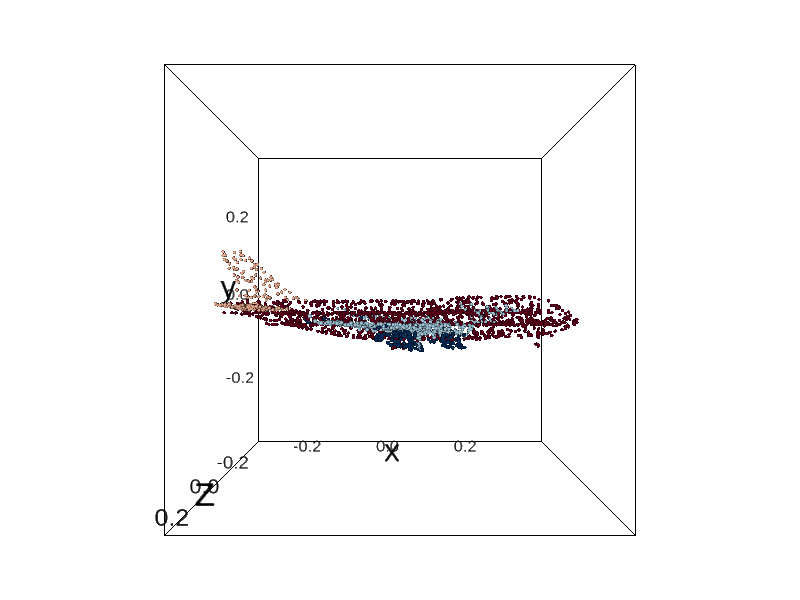

In [20]:
o.describe()
o.show()

# Transforms

## Define transforms

In order to reproduce the [example of SparseConvNet](https://github.com/facebookresearch/SparseConvNet/tree/master/examples/3d_segmentation), the same transformations have been redone, but in the manner of fast.ai transformations.

The following cells define the transformations: preprocessing (PRE_TFMS); augmentation (AUGS_); and transformation to convert the points cloud to a sparse representation (SPARSE_TFMS). Sparse  representation is the input format for the SparseConvNet model and contains a list of voxels and their features

In [21]:
resolution = 24

PRE_TFMS = [
           T.fit_to_sphere(center=False),
           T.shift_labels(offset=-1)
           ]

AUGS_TRAIN = [
    T.rotate(),
    T.flip_x(p=0.5),
]

AUGS_VALID = [
    T.rotate(),
    T.flip_x(p=0.5),
]

SPARSE_TFMS = [
    T.translate(offset=2),  # segment [-1, 1] ---> segment [1, 3]
    T.scale(scale=resolution),
    T.merge_features(ones=True),
    T.to_sparse_voxels(),
]


Let's see what we got in results of train and valid tranformations for the first example:

initial representation:

PointsItem (012843)
points                   shape: (2640, 3)             dtype: float32        min:   -0.45134,  max:    0.44987,  mean:    0.01532
labels                   shape: (2640,)               dtype: int64          min:         48,  max:         49,  mean:   48.21932


images/unet_24_detailed/fig_2.png

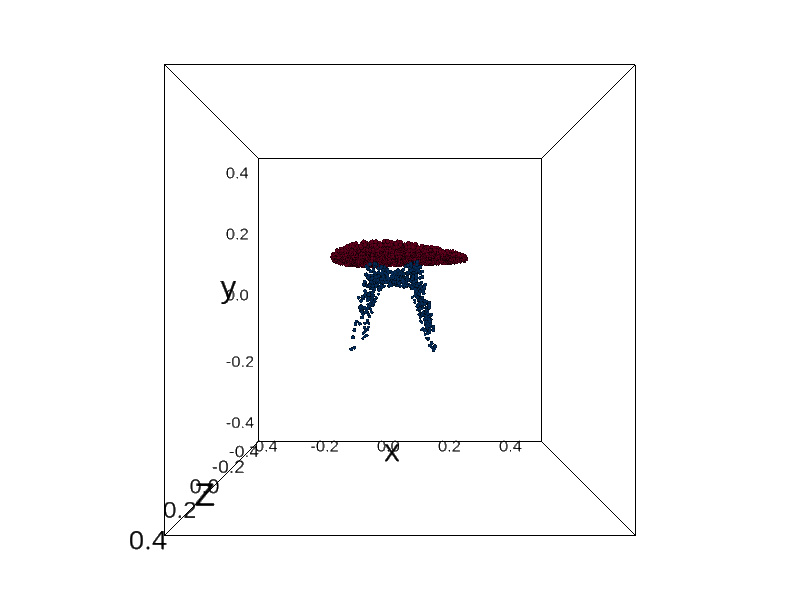

In [22]:
o = train_items[-1]
o.describe()
o.show()

transformed:

id: 012843
coords                   shape: (2640, 3)             dtype: int64          min:         27,  max:         70,  mean:   47.64508
features                 shape: (2640, 1)             dtype: float32        min:    1.00000,  max:    1.00000,  mean:    1.00000
x                        shape: (2640,)               dtype: int64          min:         27,  max:         70,  mean:   47.19735
y                        shape: (2640,)               dtype: int64          min:         34,  max:         59,  mean:   44.41023
z                        shape: (2640,)               dtype: int64          min:         40,  max:         59,  mean:   51.32765
labels                   shape: (2640,)               dtype: int64          min:         47,  max:         48,  mean:   47.21932
voxels: 1011
points / voxels: 2.6112759643916914


images/unet_24_detailed/fig_3.png

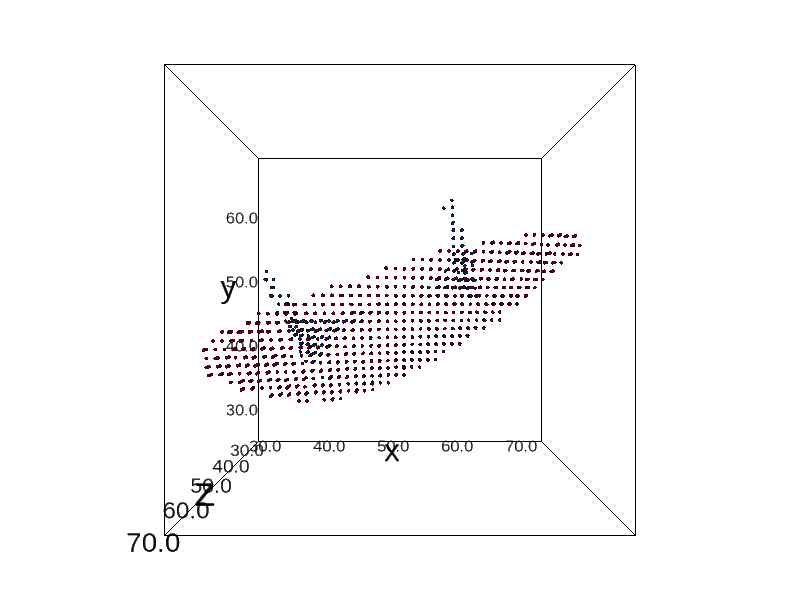

In [23]:
np.random.seed(42)
b = o.copy().apply_tfms(PRE_TFMS  + AUGS_TRAIN + SPARSE_TFMS)
b.describe()
b.show()

## Apply transforms to datasets

In [24]:
tfms = (
    PRE_TFMS + AUGS_TRAIN + SPARSE_TFMS,
    PRE_TFMS + AUGS_VALID + SPARSE_TFMS,
)

train_items.transform(tfms[0])
pass

valid_items.transform(tfms[1])
pass

# DataBunch

In fast.ai the data is represented DataBunch which contains train, valid and optionally test data loaders.

In [25]:
from fastai_sparse.data import SparseDataBunch
from data import merge_fn

In [26]:
data = SparseDataBunch.create(train_ds=train_items,
                              valid_ds=valid_items,
                              collate_fn=merge_fn,)

data.describe()

Train:  6955, shuffle:  True, batch_size: 16, num_workers: 12, num_batches: 434, drop_last: True
Valid:  7052, shuffle: False, batch_size: 16, num_workers: 12, num_batches: 441, drop_last: False


## Dataloader idle run speed measurement

In [27]:
from fastai_sparse.core import num_cpus
print("num_cpus:", num_cpus())
!lscpu | grep "Model"
print()

#data.describe()

num_cpus: 16
Model name:            AMD Ryzen 7 1700 Eight-Core Processor



In [28]:
# train
t = tqdm(enumerate(data.train_dl), total=len(data.train_dl))
for i, batch in t:
    pass

100%|██████████| 434/434 [00:04<00:00, 106.94it/s]


In [29]:
# valid
t = tqdm(enumerate(data.valid_dl), total=len(data.valid_dl))
for i, batch in t:
    pass

100%|██████████| 441/441 [00:02<00:00, 184.60it/s]


# Model

U-Net SparseConvNet implemenation ([link](https://github.com/facebookresearch/SparseConvNet/blob/master/examples/3d_segmentation/unet.py)): 

In [30]:
from fastai_sparse.learner import SparseModelConfig


model_config = SparseModelConfig(spatial_size=24 * 8, num_input_features=1)
model_config.check_accordance(data.train_ds.source_config, sparse_item=data.train_ds[0])
model_config

SparseModelConfig;
   spatial_size: 192
   dimension: 3
   block_reps: 1
   m: 32
   num_planes: [32, 64, 96, 128, 160]
   residual_blocks: False
   num_classes: 50
   num_input_features: 1
   mode: 3
   downsample: [2, 2]
   bias: False

In [31]:
class Model(nn.Module):
    def __init__(self, cfg):
        nn.Module.__init__(self)
        
        spatial_size = torch.LongTensor([cfg.spatial_size]*3)
        
        self.sparseModel = scn.Sequential(
            scn.InputLayer(cfg.dimension, spatial_size, mode=cfg.mode),
            scn.SubmanifoldConvolution(cfg.dimension, nIn=cfg.num_input_features, nOut=cfg.m, filter_size=3, bias=cfg.bias),
            scn.UNet(cfg.dimension, cfg.block_reps, cfg.num_planes, residual_blocks=cfg.residual_blocks, downsample=cfg.downsample),
            scn.BatchNormReLU(cfg.m),
            scn.OutputLayer(cfg.dimension),
        )
        self.linear = nn.Linear(cfg.m, cfg.num_classes)

    def forward(self, xb):
        coords = xb['coords']
        features = xb['features']
        x = [coords, features]

        x = self.sparseModel(x)
        x = self.linear(x)
        return x

model = Model(model_config)

In [32]:
model

Model(
  (sparseModel): Sequential(
    (0): InputLayer()
    (1): SubmanifoldConvolution 1->32 C3
    (2): Sequential(
      (0): Sequential(
        (0): BatchNormLeakyReLU(32,eps=0.0001,momentum=0.9,affine=True,leakiness=0)
        (1): SubmanifoldConvolution 32->32 C3
      )
      (1): ConcatTable(
        (0): Identity()
        (1): Sequential(
          (0): BatchNormLeakyReLU(32,eps=0.0001,momentum=0.9,affine=True,leakiness=0)
          (1): Convolution 32->64 C2/2
          (2): Sequential(
            (0): Sequential(
              (0): BatchNormLeakyReLU(64,eps=0.0001,momentum=0.9,affine=True,leakiness=0)
              (1): SubmanifoldConvolution 64->64 C3
            )
            (1): ConcatTable(
              (0): Identity()
              (1): Sequential(
                (0): BatchNormLeakyReLU(64,eps=0.0001,momentum=0.9,affine=True,leakiness=0)
                (1): Convolution 64->96 C2/2
                (2): Sequential(
                  (0): Sequential(
             

In [33]:
utils.print_trainable_parameters(model)

Total: 3,841,234


,name,number,shape
0,sparseModel.1.weight,864,27 x 1 x 32
1,sparseModel.2.0.0.weight,32,32
2,sparseModel.2.0.0.bias,32,32
3,sparseModel.2.0.1.weight,27648,27 x 32 x 32
4,sparseModel.2.1.1.0.weight,32,32
5,sparseModel.2.1.1.0.bias,32,32
6,sparseModel.2.1.1.1.weight,16384,8 x 32 x 64
7,sparseModel.2.1.1.2.0.0.weight,64,64
8,sparseModel.2.1.1.2.0.0.bias,64,64
9,sparseModel.2.1.1.2.0.1.weight,110592,27 x 64 x 64


## Learner creation
Learner is core fast.ai class which contains model architecture, databunch and optimizer options and implement train loop and prediction

In [34]:
from torch import optim
from functools import partial
from fastai.callbacks.general_sched import TrainingPhase, GeneralScheduler
#from fastai.callbacks.csv_logger import CSVLogger
#from fastai.callbacks.tracker import SaveModelCallback
from fastai.callback import annealing_exp


from fastai_sparse.learner import Learner
from fastai_sparse.callbacks import TimeLogger, SaveModelCallback, CSVLogger, CSVLoggerIouByCategory

from metrics import IouByCategories


In [35]:
learn = Learner(data, model,
                opt_func=partial(optim.SGD, momentum=0.9),
                wd=1e-4,
                true_wd=False,
                path=str(Path('results', experiment_name)))



## Learning Rate finder
We use Learning Rate Finder provided by fast.ai library to find the optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 27.9 s, sys: 6.98 s, total: 34.9 s
Wall time: 28.3 s


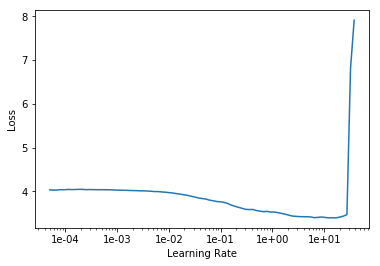

In [36]:
%%time
learn.lr_find(start_lr=1e-5, end_lr=100)
learn.recorder.plot()

# Train
To visualize the learning process, we specify some additional callbacks 

In [37]:
learn.callbacks = []
cb_iou = IouByCategories(learn, len(categories))
learn.callbacks.append(cb_iou)

learn.callbacks.append(TimeLogger(learn))
learn.callbacks.append(CSVLogger(learn))
learn.callbacks.append(CSVLoggerIouByCategory(learn, cb_iou, categories_names=classes))

learn.callbacks.append(SaveModelCallback(learn, every='epoch', name='weights', overwrite=True))

In [38]:
learn.fit_annealing_exp(3, lr=0.1, lr_decay=4e-2, momentum=0.9)

epoch,train_loss,valid_loss,train_time,valid_time,train_waiou,valid_waiou,time
0,2.066369,1.948893,121.718252,63.441886,0.451465,0.518886,03:05
1,1.672141,1.583488,121.557564,63.407442,0.548420,0.600601,03:05
2,1.318663,1.290712,122.697799,63.085566,0.616172,0.590881,03:05


In [40]:
# learn.fit_annealing_exp(100, lr=0.1, lr_decay=4e-2, momentum=0.9)

In [41]:
learn.find_callback('CSVLoggerIouByCategory').read_logged_file().tail()

,epoch,datatype,average,Airplane,Bag,Cap,Car,Chair,Earphone,Guitar,Knife,Lamp,Laptop,Motorbike,Mug,Pistol,Rocket,Skateboard,Table
1,0,valid,0.518886,0.379600,0.492501,0.414970,0.227367,0.509858,0.531944,0.484199,0.445833,0.539656,0.344094,0.231674,0.473616,0.243760,0.283587,0.391957,0.704618
2,1,train,0.548420,0.416585,0.472786,0.366650,0.240662,0.555655,0.513805,0.504931,0.574740,0.525350,0.424994,0.261024,0.484206,0.273017,0.287875,0.414793,0.719739
3,1,valid,0.600601,0.516312,0.492734,0.398441,0.268659,0.637381,0.516604,0.608734,0.617883,0.553338,0.431588,0.263243,0.545524,0.256332,0.275717,0.462712,0.747984
4,2,train,0.616172,0.543162,0.476210,0.397841,0.248176,0.669318,0.524780,0.638997,0.636003,0.541066,0.411982,0.266059,0.573489,0.281751,0.291917,0.482149,0.755185
5,2,valid,0.590881,0.523460,0.523732,0.392183,0.228041,0.613275,0.552095,0.596156,0.624740,0.534418,0.383885,0.270513,0.589842,0.294795,0.262375,0.492768,0.742103


In [42]:
learn.find_callback('CSVLogger').read_logged_file().tail()

,epoch,train_loss,valid_loss,train_time,valid_time,train_waiou,valid_waiou,time
0,0,2.066369,1.948893,121.718252,63.441886,0.451465,0.518886,03:05
1,1,1.672141,1.583488,121.557564,63.407442,0.548420,0.600601,03:05
2,2,1.318663,1.290712,122.697799,63.085566,0.616172,0.590881,03:05


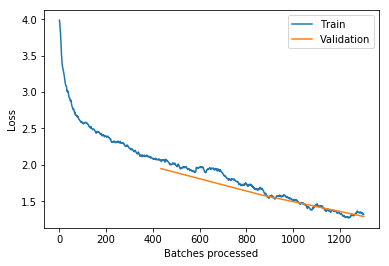

In [43]:
learn.recorder.plot_losses()

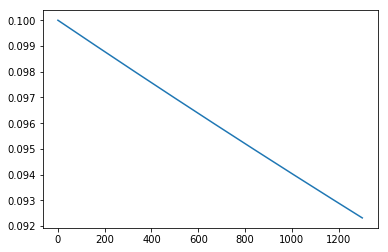

In [44]:
learn.recorder.plot_lr()

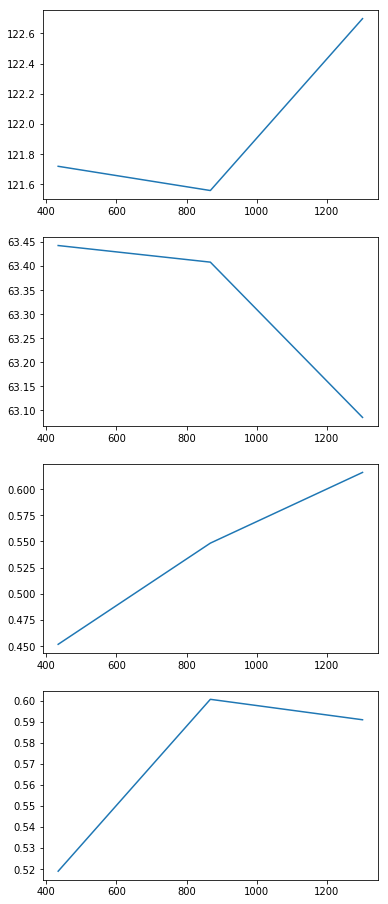

In [45]:
learn.recorder.plot_metrics()

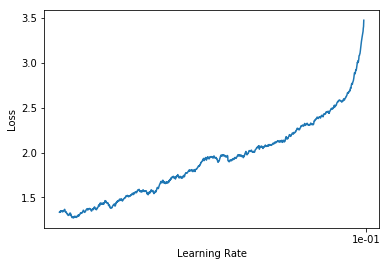

In [46]:
learn.recorder.plot()